In [443]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math
from sklearn.metrics import mean_squared_error

In [444]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

In [445]:
# Load your dataset
# Replace this with your data loading code
data = pd.read_csv('../south dakota weather data/South Dakota climate Data.csv')

In [446]:
# Choose the target columns (e.g., 'Avg. Temp', 'Min. Temp', 'Max. Temp', 'Precipitation', 'Heating Degrees Days', 'Cooling Degrees Days')
data = data[['Avg. Temp', 'Min. Temp', 'Max. Temp', 'Precipitation', 'Heating Degrees Days']].values
data = data.astype('float32') #convert values to float

In [447]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
data = scaler.fit_transform(data)

In [448]:
data

array([[0.79322034, 0.8188495 , 0.7704402 , 0.33234861, 0.04745255],
       [0.8677966 , 0.90820074, 0.8333333 , 0.50812405, 0.00999001],
       [0.8587571 , 0.89351285, 0.8291404 , 0.37666175, 0.01798202],
       ...,
       [0.3864407 , 0.376989  , 0.39308175, 0.15066469, 0.55444556],
       [0.19548023, 0.20440637, 0.18763101, 0.10044312, 0.7327672 ],
       [0.13672316, 0.13586292, 0.13836476, 0.0945347 , 0.8876124 ]],
      dtype=float32)

In [449]:
# Define the train-test split ratio (80:20)
train_size = int(len(data) * 0.90)
test_size = len(data) - train_size
train, test = data[0:train_size, :], data[train_size:len(data), :]
print(len(train))
print(len(test))

1390
155


In [450]:
def to_sequences(dataset, seq_size=6, step_size=1, target_size=6):
    x = []
    y = []

    for i in range(0, len(dataset)-seq_size-target_size + 1, step_size):
        #print(i)
        window = dataset[i:(i+seq_size)]
        x.append(window)
        target = dataset[i + seq_size: i + seq_size + target_size]
        y.append(target)
    
    return np.array(x),np.array(y)

In [451]:
seq_size = 6  # Number of time steps to look back
step_size=1  # Number of steps that is going to increase for the next sequence
num_features=5
target_size=6 # Number of values that is going to generate as the output

In [452]:
trainX, trainY = to_sequences(train, seq_size, step_size, target_size)
testX, testY = to_sequences(test, seq_size, step_size, target_size)

In [453]:
trainX.shape

(1379, 6, 5)

In [454]:
trainY.shape

(1379, 6, 5)

In [455]:
testX.shape

(144, 6, 5)

In [456]:
testY.shape

(144, 6, 5)

In [457]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [458]:
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding
import tensorflow_addons as tfa

In [459]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Attention, LayerNormalization
from tensorflow.keras.models import Model

# Define the transformer model
def transformer_model(seq_size, num_features, target_size):
    inputs = layers.Input(shape=(seq_size, num_features))
    
    # Multi-Head Self-Attention
    attention = layers.MultiHeadAttention(
        num_heads=2, key_dim=num_features, dropout=0.1
    )(inputs, inputs)
    attention = layers.LayerNormalization(epsilon=1e-6)(attention + inputs)
    
    # Feedforward layer
    outputs = layers.Conv1D(filters=64, kernel_size=1, activation="relu")(attention)
    outputs = layers.Dense(num_features)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the model
model = transformer_model(seq_size, num_features, target_size)

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 6, 5)]               0         []                            
                                                                                                  
 multi_head_attention_19 (M  (None, 6, 5)                 235       ['input_23[0][0]',            
 ultiHeadAttention)                                                  'input_23[0][0]']            
                                                                                                  
 tf.__operators__.add_19 (T  (None, 6, 5)                 0         ['multi_head_attention_19[0][0
 FOpLambda)                                                         ]',                           
                                                                     'input_23[0][0]']     

In [460]:
# Train the model
history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), callbacks=[early_stopping])

Epoch 1/100
28/28 [==============================] - 1s 8ms/step - loss: 0.2559 - mae: 0.3966 - val_loss: 0.0573 - val_mae: 0.1868
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0281 - mae: 0.1272 - val_loss: 0.0149 - val_mae: 0.0949
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0135 - mae: 0.0894 - val_loss: 0.0109 - val_mae: 0.0795
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0115 - mae: 0.0811 - val_loss: 0.0098 - val_mae: 0.0737
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0105 - mae: 0.0769 - val_loss: 0.0093 - val_mae: 0.0711
Epoch 6/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0099 - mae: 0.0746 - val_loss: 0.0089 - val_mae: 0.0690
Epoch 7/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0096 - mae: 0.0729 - val_loss: 0.0087 - val_mae: 0.0679
Epoch 8/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0094 - m

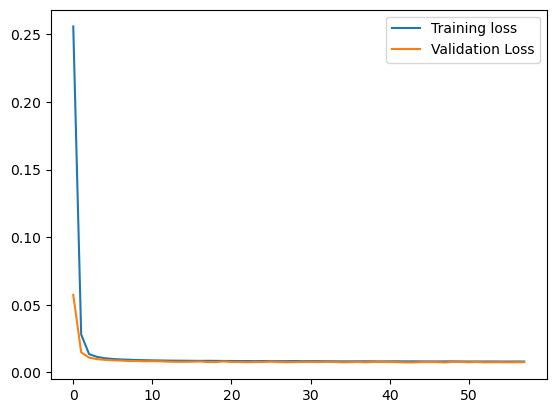

In [461]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

In [462]:
# Make predictions on the test data
testPredict = model.predict(testX)

# Inverse transform the predictions to the original scale
#testPredict = scaler.inverse_transform(testPredict)

# Optionally, inverse transform the testY (true values) if it was scaled
#testY = scaler.inverse_transform(testY)

# Now, you can compare the testY (true values) with the predicted values
# For example, to check the predictions for the first sequence:
print("True Values (TestY):")
print(testY[0])  # This contains the true values for the first sequence

print("Predicted Values:")
print(testPredict[0])  # This contains the predicted values for the first sequence

5/5 [==============================] - 0s 2ms/step
True Values (TestY):
[[0.60112995 0.61811507 0.5849057  0.6129985  0.26273727]
 [0.48700568 0.49694005 0.4769392  0.11669128 0.4110889 ]
 [0.46101692 0.47368422 0.4486373  0.06942392 0.44905096]
 [0.3062147  0.3243574  0.29140463 0.07385524 0.5949051 ]
 [0.12655367 0.13341494 0.12054508 0.1536189  0.8906094 ]
 [0.29265538 0.3133415  0.2746331  0.10782865 0.66933066]]
Predicted Values:
[[0.73733556 0.76214236 0.71623963 0.35988596 0.10377114]
 [0.59532607 0.60882676 0.5778527  0.25421533 0.27494407]
 [0.42555338 0.44142288 0.41354305 0.12972082 0.48883677]
 [0.31297892 0.32674608 0.29622138 0.09230242 0.62785685]
 [0.2829492  0.29111692 0.26325592 0.05912478 0.6924291 ]
 [0.3145204  0.3369569  0.30316466 0.07495636 0.6354798 ]]


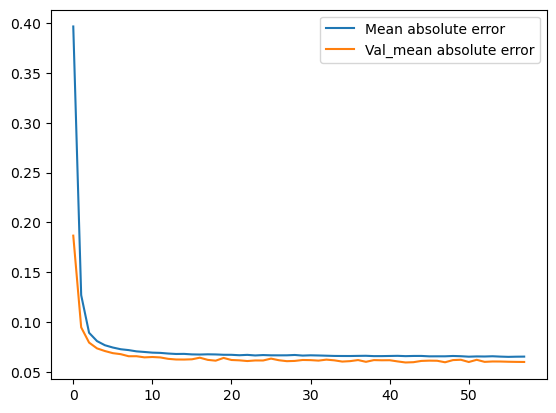

In [463]:
plt.plot(history.history['mae'],label='Mean absolute error')
plt.plot(history.history['val_mae'],label='Val_mean absolute error')
plt.legend()

In [464]:
# After training, you can make predictions on the test data
testPredict = model.predict(testX)

5/5 [==============================] - 0s 2ms/step


In [465]:
trainPredict = model.predict(trainX)

# Inverse transform the predictions to the original scale
#trainPredict = scaler.inverse_transform(trainPredict)

# Optionally, inverse transform the trainY (true values) if it was scaled
#trainY = scaler.inverse_transform(trainY)

# Now, you can compare the trainY (true values) with the predicted values
# For example, to check the predictions for the first sequence:
print("True Values (TrainY):")
print(trainY[0])  # This contains the true values for the first sequence

print("Predicted Values:")
print(trainPredict[0])  # This contains the predicted values for the first sequence


44/44 [==============================] - 0s 1ms/step
True Values (TrainY):
[[0.32881355 0.36597306 0.2976939  0.16248153 0.6228771 ]
 [0.30847457 0.32190943 0.29559746 0.10339733 0.6143856 ]
 [0.2836158  0.32680538 0.24633124 0.11669128 0.7117882 ]
 [0.23050848 0.25948593 0.20440254 0.20827177 0.7557442 ]
 [0.38757062 0.40758872 0.3710692  0.07090104 0.5194805 ]
 [0.6180791  0.61933905 0.6163522  0.08124077 0.24075924]]
Predicted Values:
[[0.3081025  0.3332849  0.3009026  0.07826397 0.63396394]
 [0.2591291  0.27725464 0.239442   0.05570296 0.7095819 ]
 [0.2642084  0.2873505  0.25310448 0.06315266 0.69196296]
 [0.27293482 0.28317875 0.25018895 0.05694259 0.70082295]
 [0.36126122 0.38545945 0.34917983 0.0955819  0.5773342 ]
 [0.6254398  0.62284786 0.60271215 0.26140013 0.2367058 ]]


In [466]:
trainPredict = model.predict(trainX)

44/44 [==============================] - 0s 1ms/step


In [467]:
# You can also optionally inverse transform the testY (true values) if it was scaled
# testY = scaler.inverse_transform(testY)

# Calculate RMSE for the test data
#testScore = math.sqrt(mean_squared_error(testY, testPredict))
#print('Test Score: %.2f RMSE' % (testScore))

# Calculate RMSE for the test data
testScore = math.sqrt(mean_squared_error(testY.reshape(-1, 5), testPredict.reshape(-1, 5)))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.09 RMSE


In [468]:
# You can also optionally inverse transform the testY (true values) if it was scaled
# testY = scaler.inverse_transform(testY)

# Calculate RMSE for the test data
#trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
#print('Train Score: %.2f RMSE' % (trainScore))

# Calculate RMSE for the train data
trainScore = math.sqrt(mean_squared_error(trainY.reshape(-1, 5), trainPredict.reshape(-1, 5)))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.09 RMSE


In [469]:
from sklearn.metrics import mean_absolute_error

# Calculate the Mean Absolute Error
#mae = mean_absolute_error(testY, testPredict)
#print("Mean Absolute Error (MAE):", mae)

# Calculate the Mean Absolute Error
mae = mean_absolute_error(testY.reshape(-1, 5), testPredict.reshape(-1, 5))
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 0.060120333


In [470]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate the Mean Absolute Percentage Error
mae = mean_absolute_percentage_error(testY.reshape(-1, 5), testPredict.reshape(-1, 5))
print("Mean Absolute Percentage Error (MAPE):", mae)

Mean Absolute Percentage Error (MAPE): 0.32251984


In [471]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate the Mean Absolute Percentage Error

trainScore = mean_absolute_percentage_error(trainY.reshape(-1, 5), trainPredict.reshape(-1, 5))
print("Mean Absolute Percentage Error (MAPE):", mae)

Mean Absolute Percentage Error (MAPE): 0.32251984


In [472]:
from sklearn.metrics import accuracy_score
# Set threshold 
threshold = 0.5
# Binarize predictions 
test_pred_binary = (testPredict > threshold).astype(int)
test_pred_binary = test_pred_binary.flatten() 

# Binarize true values
test_true_binary = (testY > threshold).astype(int) 
test_true_binary = test_true_binary.flatten()

# Calculate accuracy
test_accuracy = accuracy_score(test_true_binary, test_pred_binary)

print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9460648148148149


In [473]:
# Set threshold
threshold = 0.5

# Binarize train predictions
train_pred_binary = (trainPredict > threshold).astype(int)

# Binarize train true values
train_true_binary = (trainY > threshold).astype(int)

# Flatten arrays 
train_pred_binary = train_pred_binary.flatten()
train_true_binary = train_true_binary.flatten()

# Calculate accuracy
train_accuracy = accuracy_score(train_true_binary, train_pred_binary)

print("Train Accuracy:", train_accuracy)

Train Accuracy: 0.9430505197002659


In [475]:
predictions = model.predict(testX)

5/5 [==============================] - 0s 4ms/step


In [476]:
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
binary_ground_truth = (testY > threshold).astype(int)

In [477]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(binary_ground_truth.flatten(), binary_predictions.flatten())
recall = recall_score(binary_ground_truth.flatten(), binary_predictions.flatten())
f1 = f1_score(binary_ground_truth.flatten(), binary_predictions.flatten())

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9734953064605191
Recall: 0.9050308008213552
F1-score: 0.9380154296355413


In [478]:
from sklearn.metrics import mean_squared_error

# Assuming predictions and ground truth are NumPy arrays or lists
mse = mean_squared_error(testY.flatten(), predictions.flatten())

print("Mean Squared Error:", mse)

Mean Squared Error: 0.0075875786


In [479]:
from sklearn.metrics import r2_score

# Assuming predictions and ground truth are NumPy arrays or lists
r2 = r2_score(testY.flatten(), predictions.flatten())

print("R-squared (R2):", r2)

R-squared (R2): 0.894872877615476
